In [15]:
import numpy as np
import sklearn
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
import seaborn as sn
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import time

import lasagne
import theano.tensor as tensor
import theano
from lasagne.nonlinearities import softmax
from lasagne.layers import InputLayer, DenseLayer, get_output
from lasagne.updates import nesterov_momentum
from lasagne.updates import rmsprop
from numpy import savez

In [2]:
# Реализовать самостоятельно логистическую регрессию
# В качестве dataset'а взять Iris, оставив 2 класса:
    # Iris Versicolor
    # Iris Virginica

In [3]:
# Получаем датасет только из 2-х цветков (0 - Iris Versicolor, 1 - Iris Virginica)
iris = load_iris()
data = np.append(iris.data, [[i] for i in iris.target], axis=1)
data = data[data[:, 4] != 0]
X = np.delete(data, 4, axis=1)
y = np.delete(data, [0, 1, 2, 3], axis=1)
y = np.array([LabelEncoder().fit(y).transform(y)]).T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val = X_train
y_val = y_train

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
# Обучить ее методом градиентного спуска

In [5]:
# Вариант 1: поиск минимума через сигмоиду
sigmoid = lambda x: 1 / ( 1 + np.exp(-x) )              # сигмоида
sigmoid_deriv = lambda x: x * (1 - x)                   # производная сигмоиды
weights = np.zeros((X.shape[1], 1))                     # определяем начальные веса

best_error = max(y)

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]    # шаг изменения веса
print(f'Делаем расчет для alpha {alphas}')
time.sleep(1)

for alpha in tqdm(alphas):
    for iter in range(100000):
        l0 = X                                           # первый слой сети определяемый входными параметрами
        l1 = sigmoid(np.dot(l0, weights))                # второй слой сети определяем входными параметрами и весами
        l1_error = l1 - y                                # расчет ошибки
        l1_delta = l1_error * sigmoid_deriv(l1)          # вычисляем производную, взвешенную по ошибкам
        weights -= alpha * np.dot(l0.T, l1_delta)        # обновляем веса

        abs_error = np.mean(np.abs(l1_error))            # записываем лучший результат
        if (abs_error < best_error):
            best_error = abs_error
            best_alpha = alpha
            best_range = iter
            best_weights = weights

print(f'Мин. ошибка {best_error} при альфа {best_alpha} и N итераций {best_range} с весами:\n {best_weights}')

Делаем расчет для alpha [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]


100%|██████████| 8/8 [00:50<00:00,  6.37s/it]

Мин. ошибка 0.02077772284144448 при альфа 10 и N итераций 21 с весами:
 [[-211.3390753 ]
 [-190.43848797]
 [ 177.63367678]
 [ 152.24265048]]


Оценка точности на TRAIN выборке 1.0
Оценка точности на TEST выборке 0.9

Confusion matrix показывает, что количество истинно отрицательных - максимальное, 
что указывает о высокой точности предсказаний.
Heatmap для тестовой выборки:



/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


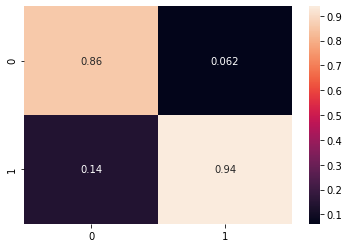

In [6]:
# Вариант 2: поиск минимума через стохастический градиентный пуск
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train, y_train)
print(f'Оценка точности на TRAIN выборке {round(clf.score(X_train, y_train), 2)}')
print(f'Оценка точности на TEST выборке {round(clf.score(X_test, y_test), 2)}\n')
print("Confusion matrix показывает, что количество истинно отрицательных - максимальное, \n\
что указывает о высокой точности предсказаний.")
print('Heatmap для тестовой выборки:\n')
sn.heatmap(confusion_matrix(y_test, 
           clf.predict(X_test), 
           labels=[1, 0],
           normalize='pred'), annot=True)

Мин. ошибка 0.005 при альфа N итераций 1572977 с весами:
 [-15.90698664 -32.02311331  32.15963363  22.10780217]
Heatmap для тестовой выборки:



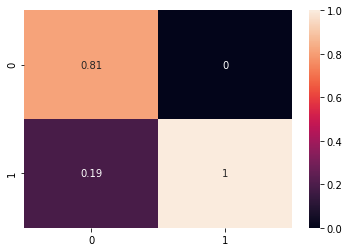

In [12]:
# Вариант 3: поиск минимума через сигмоиду методом градиентного спуска
# Определяем параметры модели для смещения (веса)
W = theano.shared(value=np.zeros((1, X_train.shape[1]), dtype=theano.config.floatX), name='W')

# Опредеяем параметры модели
x = tensor.matrix('x')
y = tensor.ivector('y')

# Определяем линейную функцию и границу вероятности
linear_function = tensor.dot(x, W[0])
sigmoid = tensor.nnet.sigmoid(linear_function)
y_pred = lambda sigmoid: 1 if sigmoid > 0.5 else 0

# Определяем функцию потерь
loss = tensor.nnet.binary_crossentropy(sigmoid, y).mean()

# Определяем градиентный спуск для параметров функции
gradient_W = tensor.grad(loss, W)
updates = [(W, W - 0.04 * gradient_W)]

# Компилируем функцию
train_function = theano.function([x, y], loss, updates=updates, allow_input_downcast=True)
predict_function = theano.function([x], sigmoid)
theano.config.exception_verbosity='high'

# Начинаем процесс обучения
loss = 100
iter = 1
while loss > 0.005:
    loss = train_function(X_train, y_train.T[0])
    iter += 1

print(f'Мин. ошибка {round(float(loss), 4)} при альфа N итераций {iter} с весами:\n {W.get_value()[0]}')
print('Heatmap для тестовой выборки:\n')
sn.heatmap(confusion_matrix(y_test, 
           np.array(list(map(y_pred, predict_function(X_test)))), 
           labels=[1, 0],
           normalize='pred'), annot=True)

In [13]:
# Методом nesterov momentum
# Определяем входной слой равный размеру тренировочной выборки
l_in = InputLayer((X_train.shape[0], X_train.shape[1]))

# Полносвязный промежуточный слой
l1 = DenseLayer(l_in, num_units=800, nonlinearity=softmax)

# Опредеяем параметры модели
x = tensor.matrix('x')  # shp: num_batch x num_features
y = tensor.ivector('y') # shp: num_batch

# Создаем функцию, которая возвращает граф построенной сети
l_out = get_output(l1, x)
l_out_prediction = lasagne.layers.get_output(l1, x, deterministic=True)

# Определяем параметры модели
params = lasagne.layers.get_all_params(l1)

# Определяем функцию потерь
loss = tensor.mean(tensor.nnet.categorical_crossentropy(l_out, y))
loss_prediction = tensor.mean(tensor.nnet.categorical_crossentropy(l_out_prediction, y))

# Определяем функцию оптимизацию - метод стохастического градиентного спуска с моментом Нестерова
updates = nesterov_momentum(loss, params, learning_rate=1e-4, momentum=.9)

# Определяем функцию точности классификатора
test_acc = tensor.mean(tensor.eq(tensor.argmax(l_out_prediction, axis=1), y), dtype=theano.config.floatX)

# Компилируем функцию
train_function = theano.function([x, y], loss, updates=updates, allow_input_downcast=True)
predict_function = theano.function([x, y], [loss_prediction, test_acc], allow_input_downcast=True)


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0], batchsize):
        end_idx = min(start_idx + batchsize, inputs.shape[0])
        if shuffle:
            excerpt = indices[start_idx:end_idx]
        else:
            excerpt = slice(start_idx, end_idx)
        yield inputs[excerpt], targets[excerpt]

loss = 100
iter = 1
while loss > 0.05:
    loss = train_function(X_train, y_train.T[0])
    err, acc = predict_function(X_test, y_test.T[0])

print(f'Ошибка на обучающий выборке: {round(float(loss), 4)}, \
ошибка на тренировочной выборке: {round(float(err), 4)}, точность на тренирочной выборке: {round(float(acc), 4)}')

Ошибка на обучающий выборке: 0.05, ошибка на тренировочной выборке: 0.251, точность на тренирочной выборке: 0.9


In [16]:
# Методом rmsprop
# Определяем входной слой равный размеру тренировочной выборки
l_in = InputLayer((X_train.shape[0], X_train.shape[1]))

# Полносвязный промежуточный слой
l1 = DenseLayer(l_in, num_units=800, nonlinearity=softmax)

# Опредеяем параметры модели
x = tensor.matrix('x')  # shp: num_batch x num_features
y = tensor.ivector('y') # shp: num_batch

# Создаем функцию, которая возвращает граф построенной сети
l_out = get_output(l1, x)
l_out_prediction = lasagne.layers.get_output(l1, x, deterministic=True)

# Определяем параметры модели
params = lasagne.layers.get_all_params(l1)

# Определяем функцию потерь
loss = tensor.mean(tensor.nnet.categorical_crossentropy(l_out, y))
loss_prediction = tensor.mean(tensor.nnet.categorical_crossentropy(l_out_prediction, y))

# Определяем функцию оптимизацию - метод стохастического градиентного спуска с моментом Нестерова
updates = rmsprop(loss, params, learning_rate=1e-4)

# Определяем функцию точности классификатора
test_acc = tensor.mean(tensor.eq(tensor.argmax(l_out_prediction, axis=1), y), dtype=theano.config.floatX)

# Компилируем функцию
train_function = theano.function([x, y], loss, updates=updates, allow_input_downcast=True)
predict_function = theano.function([x, y], [loss_prediction, test_acc], allow_input_downcast=True)


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0], batchsize):
        end_idx = min(start_idx + batchsize, inputs.shape[0])
        if shuffle:
            excerpt = indices[start_idx:end_idx]
        else:
            excerpt = slice(start_idx, end_idx)
        yield inputs[excerpt], targets[excerpt]

loss = 100
iter = 1
while loss > 0.05:
    loss = train_function(X_train, y_train.T[0])
    err, acc = predict_function(X_test, y_test.T[0])

print(f'Ошибка на обучающий выборке: {round(float(loss), 4)}, \
ошибка на тренировочной выборке: {round(float(err), 4)}, точность на тренирочной выборке: {round(float(acc), 4)}')

Ошибка на обучающий выборке: 0.05, ошибка на тренировочной выборке: 0.2482, точность на тренирочной выборке: 0.9
